## Basic Wave Equation Solver

In [2]:
import numpy as np
import torch

class WaveSolver():
    def __init__(self):
        super(WaveSolver, self).__init__()

        # Basic Parameter Set
        self.f = 4410      # sampling frequency
        self.T = 1/self.f    # sampling time
        self.dur = 0.1       # simulation duration

        self.numT = round(self.dur / self.T)
        self.t = np.linspace(0, self.dur, num=self.numT, endpoint=True ) # time vector

        self.numXs = 256      # spatial grid points
        self.l = 2.5          # length of the pipe
        self.xs = np.linspace(0.0, self.l, num=self.numXs, endpoint=True) # space vector

        self.c0 = 30       # propagation speed

    def solve(self):
        # FTM Stuff
        Mu = 250       # number of eigenvalues
        mu = np.arange(1, Mu+1) # 1:Mu;
        c0 = self.c0
        l = self.l
        numT = self.numT
        numXs = self.numXs

        test = 1j*c0*mu*np.pi/l

        gmu = np.concatenate((mu*np.pi/l, mu*np.pi/l))
        smu = np.concatenate((1j*c0*mu*np.pi/l, -1j*c0*mu*np.pi/l))

        K1 = lambda x: 1j*np.sin(gmu*x) # @(x) 1j*sin(gmu*x);
        K2 = lambda x: 1j*smu*np.sin(gmu*x)
        Ka1 = lambda x: 1j/c0**2*np.conj(smu)*np.sin(gmu*x)
        Ka2 = lambda x: 1j*np.sin(gmu*x)

        nmu = 1./(l/2*(c0**2*smu + np.conj(smu)))

        A = np.diag(np.exp(smu*self.T))

        #xeVec = np.array([0.1*self.l, 0.2*self.l, 0.3*self.l]) # vector of excitation positions (can be extended)
        xe = 0.1*l

        # Excitation for the wave equation is a simple delta-impulse at position xe
        # Possible extensions:
        # - excitation by a hamming window to have a more smooth excitation
        # - combination with a temporal excitation shape
        yi = Ka2(xe)*self.T # set initial values for states

        # vectors
        ybar = np.zeros((2*Mu, numT),dtype=complex)

        # set initial states
        ybar[:,0] = yi

        test = range(1,numT)

        # processing to create time progression of individual states
        for k in range(1,numT) :
            ybar[:,k] = A@ybar[:,k-1]

        # create output signal over time at a single observation position
        # (maybe this part is not necessary, therefore it is commented)
        # xo = 0.7*l
        # c1 = K1(xo)
        # y = c1@ybar # recover deflection from states (inverse transformation)
        # y = np.real(y)

        # create spatial vectors.
        # Result y_x: spatial distribution of the deflection y on the pipe at all
        # temporal sampling points
        K1_x = np.zeros((numXs, 2*Mu),dtype=complex)
        y_x = np.zeros((numXs, numT),dtype=complex)

        for xi in range(numXs) : #1:length(xs)
            K1_x[xi,:] = K1(self.xs[xi])/nmu
            y_x[xi,:] = K1_x[xi,:]@ybar

        # take the real part because there might be a small imaginary part
        y_x = np.real(y_x)
        y_x = y_x / 10**6 # scale the output to reasonable values around 1

        return y_x


Check output

 loss:nan

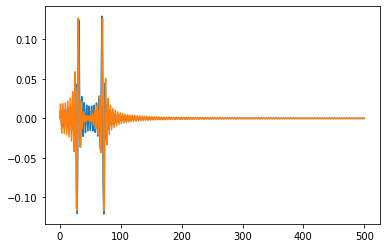

In [140]:
import matplotlib.pyplot as plt

grid_start = 0
grid_end = 1
test_grid_size = 64
field_val = 2

model_input = torch.zeros(1,grid_size,2)
model_output = torch.zeros(1,grid_size,1)

testNum = 30
model_input[:,:,:] = training_input[testNum,:,:]
model_output[:,:,:] = training_output[testNum,:,:]
#model_input = model_input.to('cuda')
input_field =  model_input[0,:,0] # training_input[10,:,0]

model_result = model(model_input)

loss = torch.nn.functional.mse_loss(model_result, model_output)
print("\r",'loss:' + str(loss.detach().cpu().numpy()), end = "")

plt.figure()
plt.plot(input_field.data)
plt.plot(model_output[0,:,0].data)
plt.plot(model_result.detach().cpu().flatten().numpy())
